# Movie Reviews Corpus Analysis with spaCy
## by Andreea Ion

## Introduction
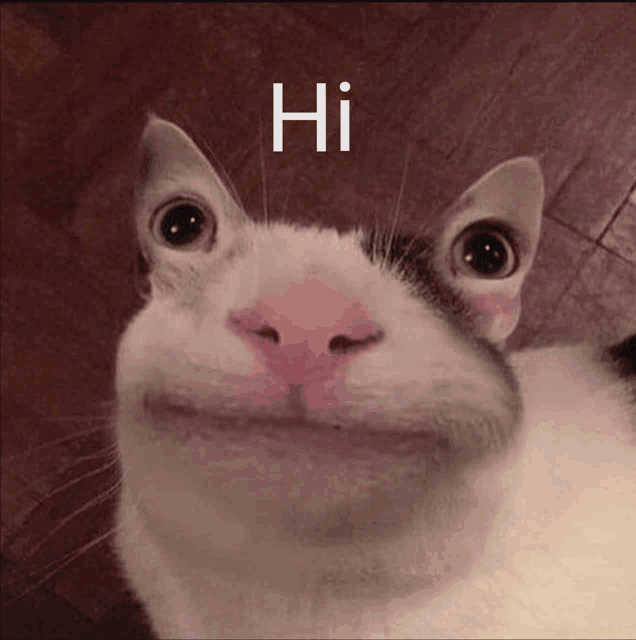
### Dataset: IMDb Movie Reviews
This project uses a small corpus of 12 IMDb movie reviews. The reviews cover three films – The Chef (2014), The Devil Wears Prada (2006), Trainspotting (1996) and Wicked (2025) – with three reviews per movie. All reviews are written in English by non-professional users and were copied from the public IMDb website (pls don't sue me?).
### Possible Research Questions:
The purpose of this assignment was to practice building a corpus. Therefore, this corpus (especially if expanded) can be used to explore various research quesitons. Some could be:

1. Do reviewers mention the character name more than actor/actress name?
2. Is the review more character-focused or plot-focused in the reviews?
3. Which adjectives/verbs/nouns are most frequently used?
4. Are there genre-specific lexical patterns (e.g. food-related vocabulary maybe for movies like The Chef)?
5. Do users use more first-person pronouns or more third-person forms?

_Note: this assignment will not be asnwering these research questions, but just stating potential research directions_

Well, for a more extensive corpora (and not just 9 reviews only) I think these questions could be nicely explored using spaCy!


### Installing, Importing and Preprocessing

In [172]:
# Import spacy
import spacy

# Install English language model
!spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------- ------------------------ 5.0/12.8 MB 27.4 MB/s eta 0:00:01
     --------------------------------- ----- 11.0/12.8 MB 28.7 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 26.7 MB/s  0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [173]:
# Import os to upload documents and metadata
import os

# Load spaCy visualizer
from spacy import displacy
from IPython.display import display, HTML
import spacy

# Import pandas DataFrame packages
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# Import graphing package
import plotly.express as px

In [174]:
# Create empty lists for file names and contents
texts = []
file_names = []

# Iterate through each file in the folder
for _file_name in os.listdir('data'):
# Look for only text files
    if _file_name.endswith('.txt'):
    # Append contents of each text file to text list
        texts.append(open('data' + '/' + _file_name, 'r', encoding='utf-8').read())
        # Append name of each file to file name list
        file_names.append(_file_name)

In [175]:
# Create dictionary object associating each file name with its text
d = {'Filename':file_names,'Text':texts}

In [176]:
# Turn dictionary into a dataframe
paper_df = pd.DataFrame(d)

In [177]:
paper_df.head()

,Filename,Text
0,Chef_1.txt,I'm no foodie but I really enjoyed this road-t...
1,Chef_2.txt,Jon Favreau is Chef Carl Casper working in a r...
2,Chef_3.txt,"Coming from blockbusters like the praised ""Iro..."
3,DWP_1.txt,We in the United States like to believe that w...
4,DWP_2.txt,his could have been a good movie if it didn't ...


The beginnings of some of the texts may contain extra spaces (indicated by \t or \n). These characters can be replaced by a single space using the str.replace() method.

In [178]:
# Remove extra spaces from papers
paper_df['Text'] = paper_df['Text'].str.replace(r'\s+', ' ', regex=True).str.strip()
paper_df.head()

,Filename,Text
0,Chef_1.txt,I'm no foodie but I really enjoyed this road-t...
1,Chef_2.txt,Jon Favreau is Chef Carl Casper working in a r...
2,Chef_3.txt,"Coming from blockbusters like the praised ""Iro..."
3,DWP_1.txt,We in the United States like to believe that w...
4,DWP_2.txt,his could have been a good movie if it didn't ...


In [179]:
# Load metadata.
metadata_df = pd.read_csv('metadata.csv')
metadata_df.head()

,MOVIE ID,TITLE,GENRE,DIRECTOR,YEAR
0,Chef_1,The Chef,Comedy,John Favreau,2014
1,Chef_2,The Chef,Comedy,John Favreau,2014
2,Chef_3,The Chef,Comedy,John Favreau,2014
3,DWP_1,The Devil Wears Prada,Drama/Comedy,David Frankel,2006
4,DWP_2,The Devil Wears Prada,Drama/Comedy,David Frankel,2006


In [180]:
# Remove .txt from title of each paper
paper_df['Filename'] = paper_df['Filename'].str.replace('.txt', '', regex=True)

# Rename column from paper ID to Title
metadata_df.rename(columns={"MOVIE ID": "Filename"}, inplace=True)

In [181]:
# Merge metadata and papers into new DataFrame
# Will only keep rows where both essay and metadata are present
final_paper_df = metadata_df.merge(paper_df,on='Filename')

Checking the head of the DataFrame again to confirm everything has worked well.

In [182]:
# Print DataFrame
final_paper_df.head()

,Filename,TITLE,GENRE,DIRECTOR,YEAR,Text
0,Chef_1,The Chef,Comedy,John Favreau,2014,I'm no foodie but I really enjoyed this road-t...
1,Chef_2,The Chef,Comedy,John Favreau,2014,Jon Favreau is Chef Carl Casper working in a r...
2,Chef_3,The Chef,Comedy,John Favreau,2014,"Coming from blockbusters like the praised ""Iro..."
3,DWP_1,The Devil Wears Prada,Drama/Comedy,David Frankel,2006,We in the United States like to believe that w...
4,DWP_2,The Devil Wears Prada,Drama/Comedy,David Frankel,2006,his could have been a good movie if it didn't ...


## Text Enrichment with spaCy

### Creating Doc Objects


To use spaCy, the first step is to load one of spaCy’s Trained Models and Pipelines which will be used to perform tokenization, part-of-speech tagging, and other text enrichment tasks.

We’ll use en_core_web_sm, which has been trained on written web texts. It may not perform as accurately as the those trained on medium and large English language models, but it will deliver results most efficiently. Once we’ve loaded en_core_web_sm, we can check what actions it performs; parser, tagger, lemmatizer, and NER, should be among those listed.

In [183]:
# Load nlp pipeline
nlp = spacy.load('en_core_web_sm')

# Check what functions it performs
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


We’ll be calling the NLP function on every text in the DataFrame, we should first define a function that runs nlp on whatever input text is given. Functions are a useful way to store operations that will be run multiple times, reducing duplications and improving code readability.

In [184]:
# Define a function that runs the nlp pipeline on any given input text
def process_text(text):
    return nlp(text)

After the function is defined, use .apply() to apply it to every cell in a given DataFrame column. In this case, nlp will run on each cell in the Text column of the final_paper_df DataFrame, creating a Doc object from every movie review text. These Doc objects will be stored in a new column of the DataFrame called Doc.

Running this function takes several minutes because spaCy is performing all the parsing and tagging tasks on each text. However, when it is complete, we can simply call on the resulting Doc objects to get parts-of-speech, named entities, and other information of interest, just as in the example of the sentence above.

In [185]:
# Apply the function to the "Text" column, so that the nlp pipeline is called on each movie review
final_paper_df['Doc'] = final_paper_df['Text'].apply(process_text)

### Text Reduction

A critical first step spaCy performs is tokenization, or the segmentation of strings into individual words and punctuation markers. Tokenization enables spaCy to parse the grammatical structures of a text and identify characteristics of each word-like part-of-speech.

To retrieve a tokenized version of each text in the DataFrame, we’ll write a function that iterates through any given Doc object and returns all functions found within it.

In [186]:
# Define a function to retrieve tokens from a doc object
def get_token(doc):
    return [(token.text) for token in doc]

We will call the function on the Doc column, since this is the column which stores the results from the processing done by spaCy.

In [187]:
# Run the token retrieval function on the doc objects in the dataframe
final_paper_df['Tokens'] = final_paper_df['Doc'].apply(get_token)
final_paper_df.head()

,Filename,TITLE,GENRE,DIRECTOR,YEAR,Text,Doc,Tokens
0,Chef_1,The Chef,Comedy,John Favreau,2014,I'm no foodie but I really enjoyed this road-t...,"(I, 'm, no, foodie, but, I, really, enjoyed, t...","[I, 'm, no, foodie, but, I, really, enjoyed, t..."
1,Chef_2,The Chef,Comedy,John Favreau,2014,Jon Favreau is Chef Carl Casper working in a r...,"(Jon, Favreau, is, Chef, Carl, Casper, working...","[Jon, Favreau, is, Chef, Carl, Casper, working..."
2,Chef_3,The Chef,Comedy,John Favreau,2014,"Coming from blockbusters like the praised ""Iro...","(Coming, from, blockbusters, like, the, praise...","[Coming, from, blockbusters, like, the, praise..."
3,DWP_1,The Devil Wears Prada,Drama/Comedy,David Frankel,2006,We in the United States like to believe that w...,"(We, in, the, United, States, like, to, believ...","[We, in, the, United, States, like, to, believ..."
4,DWP_2,The Devil Wears Prada,Drama/Comedy,David Frankel,2006,his could have been a good movie if it didn't ...,"(his, could, have, been, a, good, movie, if, i...","[his, could, have, been, a, good, movie, if, i..."


If we compare the Text and Tokens column, we find a couple of differences. In the table below, the words, spaces, and punctuation markers in the Tokens column are separated by commas, indicating that each have been parsed as individual tokens. The text in the Tokens column is also bracketed; this indicates that tokens have been generated as a list.

In [188]:
tokens = final_paper_df[['Text', 'Tokens']].copy()
tokens.head()

,Text,Tokens
0,I'm no foodie but I really enjoyed this road-t...,"[I, 'm, no, foodie, but, I, really, enjoyed, t..."
1,Jon Favreau is Chef Carl Casper working in a r...,"[Jon, Favreau, is, Chef, Carl, Casper, working..."
2,"Coming from blockbusters like the praised ""Iro...","[Coming, from, blockbusters, like, the, praise..."
3,We in the United States like to believe that w...,"[We, in, the, United, States, like, to, believ..."
4,his could have been a good movie if it didn't ...,"[his, could, have, been, a, good, movie, if, i..."


#### Lemmatization

Another process performed by spaCy is lemmatization, or the retrieval of the dictionary root word of each word (for example “brighten” for “brightening”). We’ll perform a similar set of steps to those above to create a function to call the lemmas from the Doc object, then apply it to the DataFrame.

In [189]:
# Define a function to retrieve lemmas from a doc object
def get_lemma(doc):
    return [(token.lemma_) for token in doc]

# Run the lemma retrieval function on the doc objects in the dataframe
final_paper_df['Lemmas'] = final_paper_df['Doc'].apply(get_lemma)

Lemmatization can help reduce noise and refine results for researchers who are conducting keyword searches. For example, let’s compare counts of the word “recommend” in the original Tokens column and in the lemmatized Lemmas column.

In [214]:
print(f'"Watch" appears in the text tokens column ' + str(final_paper_df['Tokens'].apply(lambda x: x.count('watch')).sum()) + ' times.')
print(f'"Watch" appears in the lemmas column ' + str(final_paper_df['Lemmas'].apply(lambda x: x.count('watch')).sum()) + ' times.')

"Watch" appears in the text tokens column 5 times.
"Watch" appears in the lemmas column 12 times.


As expected, there are more instances of “watch” in the Lemmas column, as the lemmatization process has grouped inflected word forms (watched, watching, etc.) into the base word “watch”.

### Text Annotation

#### Part of Speech Tagging

spaCy facilitates two levels of part-of-speech tagging: coarse-grained tagging, which predicts the simple universal part-of-speech of each token in a text (such as noun, verb, adjective, adverb), and detailed tagging, which uses a larger, more fine-grained set of part-of-speech tags (for example 3rd person singular present verb). The part-of-speech tags used are determined by the English language model we use. In this case, we’re using the small English model, and you can explore the differences between the models on spaCy’s website.

We can call the part-of-speech tags in the same way as the lemmas. Create a function to extract them from any given Doc object and apply the function to each Doc object in the DataFrame. The function we’ll create will extract both the coarse- and fine-grained part-of-speech for each token (token.pos_ and token.tag_, respectively).

In [191]:
# Define a function to retrieve lemmas from a doc object
def get_pos(doc):
    #Return the coarse- and fine-grained part of speech text for each token in the doc
    return [(token.pos_, token.tag_) for token in doc]

# Define a function to retrieve parts of speech from a doc object
final_paper_df['POS'] = final_paper_df['Doc'].apply(get_pos)

We can create a list of the part-of-speech columns to review them further. The first (coarse-grained) tag corresponds to a generally recognizable part-of-speech such as a noun, adjective, or punctuation mark, while the second (fine-grained) category are a bit more difficult to decipher.

In [192]:
# Create a list of part of speech tags
list(final_paper_df['POS'])

[[('PRON', 'PRP'),
  ('AUX', 'VBP'),
  ('DET', 'DT'),
  ('NOUN', 'NN'),
  ('CCONJ', 'CC'),
  ('PRON', 'PRP'),
  ('ADV', 'RB'),
  ('VERB', 'VBD'),
  ('DET', 'DT'),
  ('NOUN', 'NN'),
  ('PUNCT', 'HYPH'),
  ('NOUN', 'NN'),
  ('SYM', 'SYM'),
  ('PROPN', 'NNP'),
  ('PUNCT', 'HYPH'),
  ('NOUN', 'NN'),
  ('PUNCT', ','),
  ('PROPN', 'NNP'),
  ('NOUN', 'NN'),
  ('PUNCT', ','),
  ('VERB', 'VBN'),
  ('VERB', 'VBN'),
  ('ADP', 'IN'),
  ('CCONJ', 'CC'),
  ('VERB', 'VBG'),
  ('PROPN', 'NNP'),
  ('PROPN', 'NNP'),
  ('PUNCT', ','),
  ('VERB', 'VBN'),
  ('ADP', 'IN'),
  ('DET', 'DT'),
  ('ADJ', 'JJ'),
  ('NOUN', 'NN'),
  ('CCONJ', 'CC'),
  ('NOUN', 'NNS'),
  ('ADP', 'IN'),
  ('DET', 'DT'),
  ('NOUN', 'NN'),
  ('NOUN', 'NN'),
  ('PRON', 'WP'),
  ('VERB', 'VBZ'),
  ('PART', 'TO'),
  ('VERB', 'VB'),
  ('PRON', 'PRP$'),
  ('ADJ', 'JJ'),
  ('NOUN', 'NN'),
  ('ADP', 'IN'),
  ('DET', 'DT'),
  ('NOUN', 'NNS'),
  ('ADP', 'IN'),
  ('PRON', 'PRP$'),
  ('ADJ', 'JJ'),
  ('NOUN', 'NN'),
  ('NOUN', 'NN'),
  ('PUNCT',

Fortunately, spaCy has a built-in function called explain that can provide a short description of any tag of interest. If we try it on the tag IN using spacy.explain("IN"), the output reads conjunction, subordinating or preposition.

In [193]:
spacy.explain("IN")

'conjunction, subordinating or preposition'

In some cases, we might want to get only a set of part-of-speech tags for further analysis, like all of the proper nouns. A function can be written to perform this task, extracting only words which have been fitted with the proper noun tag.

In [194]:
# Define function to extract proper nouns from Doc object
def extract_proper_nouns(doc):
    return [token.text for token in doc if token.pos_ == 'PROPN']

# Apply function to Doc column and store resulting proper nouns in new column
final_paper_df['Proper_Nouns'] = final_paper_df['Doc'].apply(extract_proper_nouns)

Listing the nouns in each text can help us ascertain the texts’ subjects. Let’s list the nouns in two different texts, the text located in row 2 of the DataFrame and the text located in row 3.

In [195]:
list(final_paper_df.loc[[2, 3], 'Proper_Nouns'])

[['Iron',
  'Man',
  'Cowboys',
  'Aliens",and',
  'Jon',
  'Favreau',
  'Chef',
  'Chef',
  'Carl',
  'Casper',
  'Favreau',
  'Robert',
  'Downey',
  'Jr.',
  'Scarlett',
  'Johansson',
  'Sofia',
  'Vergara',
  'Dustin',
  'Hoffman',
  'Emjay',
  'Anthony',
  'Chef',
  'Twitter',
  'El',
  'Jefes',
  'Vine',
  'Chef',
  'Jon',
  'Favreau',
  'Jungle',
  'Book'],
 ['United',
  'States',
  'Entertainment',
  'Media',
  'Industries',
  'Wears',
  'Prada',
  'Wears',
  'Prada',
  'Runway',
  'Bill',
  'Gates',
  'Miranda',
  'Priestly',
  'Meryl',
  'Streep',
  'Oscar',
  'Vogue',
  'Magazine',
  'Anna',
  'Wintour',
  'Runway',
  'Mirander',
  'serfs',
  'Andy',
  'Sachs',
  'Madison',
  'Avenue',
  'Northwestern',
  'Andy',
  'New',
  'York',
  'Mirander',
  'Mirander',
  'Lady',
  'Manor',
  'Streep',
  'Superman',
  'Andy',
  'Miranda',
  'Andy',
  'Christian',
  'Dior',
  'Runway',
  'Vogue']]

Extracting proper nouns from each review gives a quick snapshot of the main people, places and cultural references in the text. For The Chef review, the focus is on the director, cast, and other films he is associated with, while The Devil Wears Prada review foregrounds fashion magazines, editors, and New York settings. This shows how POS-based extraction can help us identify topics, intertextual references, and the different thematic emphases across reviews.

#### Named Entity Recognition

spaCy can tag named entities in the text, such as names, dates, organizations, and locations. Call the full list of named entities and their descriptions using this code:

In [196]:
# Get all NE labels and assign to variable
labels = nlp.get_pipe("ner").labels

# Print each label and its description
for label in labels:
    print(label + ' : ' + spacy.explain(label))

CARDINAL : Numerals that do not fall under another type
DATE : Absolute or relative dates or periods
EVENT : Named hurricanes, battles, wars, sports events, etc.
FAC : Buildings, airports, highways, bridges, etc.
GPE : Countries, cities, states
LANGUAGE : Any named language
LAW : Named documents made into laws.
LOC : Non-GPE locations, mountain ranges, bodies of water
MONEY : Monetary values, including unit
NORP : Nationalities or religious or political groups
ORDINAL : "first", "second", etc.
ORG : Companies, agencies, institutions, etc.
PERCENT : Percentage, including "%"
PERSON : People, including fictional
PRODUCT : Objects, vehicles, foods, etc. (not services)
QUANTITY : Measurements, as of weight or distance
TIME : Times smaller than a day
WORK_OF_ART : Titles of books, songs, etc.


We’ll create a function to extract the named entity tags from each Doc object and apply it to the Doc objects in the DataFrame, storing the named entities in a new column:

In [197]:
# Define function to extract named entities from doc objects
def extract_named_entities(doc):
    return [ent.label_ for ent in doc.ents]

# Apply function to Doc column and store resulting named entities in new column
final_paper_df['Named_Entities'] = final_paper_df['Doc'].apply(extract_named_entities)
final_paper_df['Named_Entities']

0       [PERSON, CARDINAL, ORDINAL, DATE, PERSON, TIME]
1     [PERSON, PERSON, PERSON, PERSON, PERSON, PERSO...
2     [WORK_OF_ART, WORK_OF_ART, PERSON, NORP, TIME,...
3     [GPE, ORG, ORG, DATE, WORK_OF_ART, CARDINAL, W...
4     [PERSON, PERSON, CARDINAL, PERSON, PERSON, PER...
5     [ORDINAL, DATE, ORDINAL, PERSON, PERSON, PERSO...
6     [CARDINAL, ORG, PERSON, PERSON, ORG, PERSON, P...
7     [FAC, CARDINAL, ORDINAL, CARDINAL, PERSON, ORG...
8     [PERSON, ORG, ORG, ORDINAL, CARDINAL, PERSON, ...
9     [GPE, PERSON, PERSON, PERSON, PERSON, GPE, ORD...
10    [PERSON, DATE, DATE, CARDINAL, GPE, DATE, CARD...
11    [PERSON, PERSON, CARDINAL, GPE, ORG, GPE, PERS...
Name: Named_Entities, dtype: object

We can add another column with the words and phrases identified as named entities:

In [198]:
# Define function to extract text tagged with named entities from doc objects
def extract_named_entities(doc):
    return [ent for ent in doc.ents]

# Apply function to Doc column and store resulting text in new column
final_paper_df['NE_Words'] = final_paper_df['Doc'].apply(extract_named_entities)
final_paper_df['NE_Words']

0     [(Jon, Favreau), (1), (second), (10, year, old...
1     [(Jon, Favreau), (Carl, Casper), (Carl), (Carl...
2     [(Iron, Man), (Cowboys, &, Aliens",and), (Favr...
3     [(the, United, States), (Entertainment), (Medi...
4     [(Andy), (Andy), (one), (Andy), (Andy), (Andy)...
5     [(second), (many, many, years), (first), (Andy...
6     [(One), (Ariana, Grande), (Cynthia, Erivo), (O...
7     [(Broadway), (two), (second), (One), (John, M....
8     [(Cynthia, Erivo), (Ariana, Grande), (Glinda),...
9     [(Edinburgh), (Renton), (McGregor), (Renton), ...
10    [(Danny, Boyle, 's), (2008), (1996), (less-, t...
11    [(Danny, Boyle, 's), (Irvine, Welsh, 's), (One...
Name: NE_Words, dtype: object

In [199]:
# Extract the first Doc object
doc = final_paper_df['Doc'][1]

# Visualize named entity tagging in a single paper
#displacy.render(doc, style='ent', jupyter=True) #ipython >=8.0 and <9.0 needed to use displacy

Here, a visualization of the words and their named entity tags in a single text should have been generated. Unfortunately, due to my ipython and spaCy version, this resulted in an error.I tried running 'conda install ipython=8 -c conda-forge' in the terminal and restarting the project, but I still got the error.

### Download Enriched Dataset

To save the dataset of doc objects, text reductions and linguistic annotations generated with spaCy, download the final_paper_df DataFrame to your local computer as a .csv file:

In [200]:
# Save DataFrame as csv (in Google Drive)
# Use this step only to save  csv to your computer's working directory
final_paper_df.to_csv('annotated_data.csv')

## Analysis of Linguistic Annotations

Why are spaCy’s linguistic annotations useful to researchers? Below are two examples of how researchers can use data about the corpus, produced through spaCy, to draw conclusions about discipline and genre conventions in student academic writing. We will use the enriched dataset generated with spaCy for these examples.


### Part of Speech Analysis
In this section, we’ll analyze the part-of-speech tags extracted by spaCy

In [201]:
# Store dictionary with indexes and POS counts in a variable
num_pos = doc.count_by(spacy.attrs.POS)

dictionary = {}

# Create a new dictionary which replaces the index of each part of speech for its label (NOUN, VERB, ADJECTIVE)
for k,v in sorted(num_pos.items()):
    dictionary[doc.vocab[k].text] = v

dictionary

{'ADJ': 22,
 'ADP': 26,
 'ADV': 17,
 'AUX': 13,
 'CCONJ': 13,
 'DET': 25,
 'NOUN': 52,
 'NUM': 3,
 'PART': 8,
 'PRON': 27,
 'PROPN': 21,
 'PUNCT': 26,
 'SCONJ': 6,
 'VERB': 35}

In [202]:
# Create new DataFrame for analysis purposes
pos_analysis_df = final_paper_df[['Filename','TITLE', 'Doc']]

# Create list to store each dictionary
num_list = []

# Define a function to get part of speech tags and counts and append them to a new dictionary
def get_pos_tags(doc):
    dictionary = {}
    num_pos = doc.count_by(spacy.attrs.POS)
    for k,v in sorted(num_pos.items()):
        dictionary[doc.vocab[k].text] = v
    num_list.append(dictionary)

# Apply function to each doc object in DataFrame
pos_analysis_df.loc['C_POS'] = pos_analysis_df['Doc'].apply(get_pos_tags)

From here, we’ll take the part-of-speech counts and put them into a new DataFrame where we can calculate the frequency of each part-of-speech per document. In the new DataFrame, if a paper does not contain a particular part-of-speech, the cell will read NaN (Not a Number).

In [203]:
# Create new dataframe with part of speech counts
pos_counts = pd.DataFrame(num_list)
columns = list(pos_counts.columns)

# Add title of each movie as new column to dataframe
idx = 0
new_col = pos_analysis_df['TITLE']
pos_counts.insert(loc=idx, column='TITLE', value=new_col)

pos_counts

,TITLE,ADJ,ADP,ADV,AUX,CCONJ,DET,NOUN,NUM,PART,PRON,PROPN,PUNCT,SYM,VERB,SCONJ,X,INTJ
0,The Chef,32,35,19,7,13,28,62,2,4,23,7,26,1.0,30,NaN,NaN,NaN
1,The Chef,22,26,17,13,13,25,52,3,8,27,21,26,NaN,35,6.0,NaN,NaN
2,The Chef,38,38,21,17,13,52,68,7,13,17,32,55,2.0,42,8.0,2.0,NaN
3,The Devil Wears Prada,58,105,40,51,22,105,190,6,26,92,45,131,NaN,110,18.0,NaN,1.0
4,The Devil Wears Prada,32,49,34,41,14,49,77,3,25,69,18,64,NaN,62,19.0,NaN,NaN
5,The Devil Wears Prada,80,144,89,62,52,112,206,5,44,146,35,114,NaN,155,35.0,NaN,3.0
6,Wicked,25,45,23,17,20,36,64,2,11,33,23,36,1.0,44,5.0,NaN,NaN
7,Wicked,42,54,16,21,16,38,59,13,9,25,61,27,NaN,43,7.0,NaN,NaN
8,Wicked,36,29,22,11,14,23,63,3,8,22,35,57,NaN,37,11.0,NaN,NaN
9,Trainspotting,24,26,9,10,11,27,52,1,4,24,10,20,NaN,31,4.0,NaN,NaN


We can calculate the amount of times, on average, that each part-of-speech appears in each movie, using the .groupby() and .mean() functions to group all part-of-speech counts from the texts together and calculate the mean usage of each part-of-speech

In [204]:
# Get average part of speech counts used in papers of each movie
average_pos_df = pos_counts.groupby(['TITLE']).mean()

# Round calculations to the nearest whole number
average_pos_df = average_pos_df.round(0)

# Reset index to improve DataFrame readability
average_pos_df = average_pos_df.reset_index()

# Show dataframe
average_pos_df

,TITLE,ADJ,ADP,ADV,AUX,CCONJ,DET,NOUN,NUM,PART,PRON,PROPN,PUNCT,SYM,VERB,SCONJ,X,INTJ
0,The Chef,31.0,33.0,19.0,12.0,13.0,35.0,61.0,4.0,8.0,22.0,20.0,36.0,2.0,36.0,7.0,2.0,NaN
1,The Devil Wears Prada,57.0,99.0,54.0,51.0,29.0,89.0,158.0,5.0,32.0,102.0,33.0,103.0,NaN,109.0,24.0,NaN,2.0
2,Trainspotting,53.0,50.0,26.0,30.0,25.0,52.0,98.0,6.0,17.0,45.0,39.0,64.0,1.0,58.0,9.0,NaN,1.0
3,Wicked,34.0,43.0,20.0,16.0,17.0,32.0,62.0,6.0,9.0,27.0,40.0,40.0,1.0,41.0,8.0,NaN,NaN


Here we can examine the differences between average part-of-speech usage per movie. Here we can examine the differences between average part-of-speech usage per movie. The reviews for The Devil Wears Prada are clearly the most lexically dense: on average they contain almost twice as many adjectives (57) as the reviews for The Chef (31) and Wicked (34), and substantially more verbs (109) than any of the other films (58 for Trainspotting, 41 for Wicked, and 36 for The Chef). This difference might occur due to the different lenghts of the corpus.
With a much larger corpus, the results could be more reliable.
By contrast, The Chef and Wicked use far fewer nouns and pronouns overall, reflecting more compact reviews. Interestingly, proper nouns (PROPN) are especially frequent in the reviews for Trainspotting (39) and Wicked (40), indicating a heavier emphasis on named characters, places and cultural references in those discussions.
Numbers (NUM) are low and fairly even across all four films (4–6 per review), suggesting that reviewers rarely rely on quantitative information in any of these movie discussions.

In [205]:
# Use plotly to plot proper noun use per genre
fig = px.bar(average_pos_df, x="TITLE", y=["ADJ", 'VERB', "NUM"], title="Average Part-of-Speech Use in IMDb Movie Reviews", barmode='group')
fig.show()

Though admittedly a simple analysis, calculating part-of-speech frequency counts affirms prior studies which posit a correlation between lexico-grammatical features and disciplinary conventions, suggesting this application of spaCy can be adapted to serve other researchers’ corpora and part-of-speech usage queries.

### Named Entity Analysis

In this section, named entity tags extracted from spaCy was used.
 we’ll create a new DataFrame with the text filenames, titles, and named entity words and tags:

In [206]:
# Create new DataFrame for analysis purposes
ner_analysis_df = final_paper_df[['Filename','TITLE', 'Named_Entities', 'NE_Words']]

Using the str.count method, we can get counts of a specific named entity used in each text. Let’s get the counts of the named entities of interest here (PERSON, ORG, DATE, and WORKS_OF_ART) and add them as new columns of the DataFrame.

In [207]:
# Convert named entity lists to strings so we can count specific entities
ner_analysis_df['Named_Entities'] = ner_analysis_df['Named_Entities'].apply(lambda x: ' '.join(x))

# Get the number of each type of entity in each paper
person_counts = ner_analysis_df['Named_Entities'].str.count('PERSON')
date_counts = ner_analysis_df['Named_Entities'].str.count('DATE')
woa_counts = ner_analysis_df['Named_Entities'].str.count('WORK_OF_ART')
org_counts = ner_analysis_df['Named_Entities'].str.count('ORG')

# Append named entity counts to new DataFrame
ner_counts_df = pd.DataFrame()
ner_counts_df['Title'] = ner_analysis_df["TITLE"]
ner_counts_df['PERSON_Counts'] = person_counts
ner_counts_df['DATE_Counts'] = date_counts
ner_counts_df['WORK_OF_ART_Counts'] = woa_counts
ner_counts_df['ORG_Counts'] = org_counts

ner_counts_df.head(12)

,Title,PERSON_Counts,DATE_Counts,WORK_OF_ART_Counts,ORG_Counts
0,The Chef,2,1,0,0
1,The Chef,12,1,0,0
2,The Chef,10,3,3,1
3,The Devil Wears Prada,13,2,3,7
4,The Devil Wears Prada,10,0,0,1
5,The Devil Wears Prada,17,5,1,4
6,Wicked,8,0,1,2
7,Wicked,10,4,4,11
8,Wicked,6,0,1,5
9,Trainspotting,4,1,0,0


From here, we can compare the average usage of each named entity and plot across paper type.

In [208]:
# Calculate average usage of each named entity type
average_ner_df = ner_counts_df.groupby(['Title']).mean()
average_ner_df = average_ner_df.round(0)
average_ner_df = average_ner_df.reset_index()
average_ner_df

# Use plotly to plot proper noun use per genre
fig = px.bar(average_ner_df, x="Title", y=["PERSON_Counts", "DATE_Counts", 'WORK_OF_ART_Counts', 'ORG_Counts'], title="Average Named Entity Usage Across Student Paper Genres", barmode='group')
fig.show()

Across all four movies, ```PERSON``` entities are the most frequent, since reviewers naturally refer to actors and characters. Trainspotting and The Devil Wears Prada show the highest  ```PERSON``` counts, suggesting more character-focused reviews. Wicked contains the most  ```ORG``` entities, while  ```WORK_OF_ART``` mentions are slightly higher for Wicked and Thr Chef.  ```DATE``` entities remain low across all movies, indicating reviewers rarely mention specific years or time periods.

### Analysis of ```PERSON``` Named Entities

Let’s explore patterns of one of these entities’ usage (PERSON) further by retrieving the words most frequently tagged as people in various movies. Wo this by first creating functions to extract the words tagged as date entities in each document and adding the words to a new DataFrame column:

In [209]:
# Define function to extract PERSON named entities from doc objects
def extract_person_named_entities(doc):
    return [ent for ent in doc.ents if ent.label_ == 'PERSON']

# Apply to DataFrame
ner_analysis_df['Person_Named_Entities'] = final_paper_df['Doc'].apply(extract_person_named_entities)

# Convert list of PERSON entities to a string
ner_analysis_df['Person_Named_Entities'] = [', '.join(map(str, l)) for l in ner_analysis_df['Person_Named_Entities']]

Now we can retrieve only the subset of movies that are in the proposal genre, get the top words that have been tagged as “dates” in these papers and append them to a list.spaCy outputs a list of the 10 words most-frequently labeled with the DATE named entity tag in Proposal papers:

In [210]:
# Search for only person words in proposal papers
person_word_counts_df = ner_analysis_df[ner_analysis_df['TITLE'] == "The Chef"]

# Count the frequency of each word in these essays and append to list
person_word_frequencies = person_word_counts_df.Person_Named_Entities.str.split(expand=True).stack().value_counts()

# Get top 10 most common words and their frequencies
person_word_frequencies[:10]

Carl,         4
Favreau,      4
Jon           3
Johansson,    2
Sofia         2
Hoffman,      2
Dustin        2
Jr.,          2
Robert        2
Downey        2
Name: count, dtype: int64

In [211]:
# Search for only person words in proposal papers
person_word_counts_df = ner_analysis_df[ner_analysis_df['TITLE'] == "The Devil Wears Prada"]

# Count the frequency of each word in these essays and append to list
person_word_frequencies = person_word_counts_df.Person_Named_Entities.str.split(expand=True).stack().value_counts()

# Get top 10 most common words and their frequencies
person_word_frequencies[:10]

Andy,        21
Meryl         3
Streep,       2
Miranda,      2
Mirander,     2
Andy          2
Anne          2
Vogue         1
Blunt,        1
Emily         1
Name: count, dtype: int64

In [212]:
# Search for only person words in proposal papers
person_word_counts_df = ner_analysis_df[ner_analysis_df['TITLE'] == "Wicked"]

# Count the frequency of each word in these essays and append to list
person_word_frequencies = person_word_counts_df.Person_Named_Entities.str.split(expand=True).stack().value_counts()

# Get top 10 most common words and their frequencies
person_word_frequencies[:10]

Cynthia      3
Erivo,       3
Jonathan     2
Jeff         2
Goldblum,    2
Michelle     2
M.           2
Yeoh,        2
Bailey,      2
Ethan        2
Name: count, dtype: int64

In [213]:
# Search for only person words in proposal papers
person_word_counts_df = ner_analysis_df[ner_analysis_df['TITLE'] == "Trainspotting"]

# Count the frequency of each word in these essays and append to list
person_word_frequencies = person_word_counts_df.Person_Named_Entities.str.split(expand=True).stack().value_counts()

# Get top 10 most common words and their frequencies
person_word_frequencies[:10]

Renton,      9
Danny        6
-            3
Boyle,       3
Robert       3
McGregor,    3
Carlyle      2
Kevin        2
Tommy,       2
junkie,      2
Name: count, dtype: int64

Across the four movies, the most frequently mentioned ```PERSON``` entities clearly reflect the main characters or actors associated with each film. In The Chef, names like Carl, Favreau, Jon, Johansson and Hoffman dominate, showing that reviewers focus heavily on the film’s central character and its well-known cast. For The Devil Wears Prada, Andy, Meryl Streep, Miranda/Mirander, and Anne appear most often, which fits the film’s emphasis on its lead characters and high-profile actors. In Wicked, the most common entities—Cynthia, Erivo, Michelle, Jeff, and Goldblum, correspond to the actors in the  adaptation, suggesting reviewers frequently discuss casting. Finally, Trainspotting reviews highlight Renton, Danny, Boyle, and McGregor, indicating a strong focus on both the protagonist and the film’s director and star. Overall, the PERSON entity counts reliably mirror each movie’s key characters and creative figures.

### Conclusions
In this assignment, I practiced building and analyzing a small movie-review corpus using spaCy. By collecting IMDb reviews for four different films and preparing them as a structured dataset, I was able to explore several core NLP techniques, including tokenization, lemmatization, part-of-speech tagging, and named-entity recognition. Even with a small corpus, this exercise showed how computational tools can help identify linguistic patterns, highlight what reviewers focus on, and support qualitative interpretation through quantitative evidence.